# Power Price Modeling

Uses ComEd API at https://hourlypricing.comed.com/hp-api/

In [1]:
import urllib.request
import json
import datetime
import numpy
import pytz
import pandas
%matplotlib notebook
import matplotlib.pyplot
import dateutil
import pylab
import scipy.stats
import scipy.optimize
from mpl_toolkits.mplot3d import axes3d
import scipy.io

In [2]:
N_priordays=5 #want N_priodays history
Chicago=pytz.timezone("America/Chicago")

In [3]:
def get_prices(startDate,endDate=None):
    '''
    gets data from ComEd
    startDate and endDate should be in YYYYMMDDhhmm
    output is a list of {"1234",5.5}, where "1234" is the UTC in seconds and 5.5 is the price
    '''
    endDate = startDate if endDate is None else endDate
    startDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(startDate)))
    endDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(endDate)))
    format="%Y%m%d%H%M"
    startDate=startDate.strftime(format)
    endDate=endDate.strftime(format)
    URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart=STARTDATE&dateend=ENDDATE&format=text"
    temp=URL.replace("STARTDATE",startDate).replace("ENDDATE",endDate)
    print(temp)
    with urllib.request.urlopen(temp) as response:
        data = response.read().decode('utf-8')
        #print(data)
    out={}
    for obj in data.split(","):
        data=obj.split(":")
        try:
            ts=int(data[0])/1000
            dt=Chicago.normalize(Chicago.localize(datetime.datetime.fromtimestamp(ts)))
            out[dt]=float(data[1])
        except Exception:
            pass
    return out        

In [4]:
startDate="20170901"
endDate="20170930"
#make sure that there are at least N_priordays of data between startDate and endDate
data=get_prices(startDate,endDate)
print(str(len(data.keys()))+" records of data")

https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201709010000&dateend=201709300000&format=text
8299 records of data


In [5]:
def inrange(indatetime):
    '''
    returns true if datetime is between midnight and 5 AM, and a weekday
    '''
    hourflag=(datetime.time(23,0,0)<=indatetime.time()) or (indatetime.time()<=datetime.time(5,0,0))
    dayflag=0<=indatetime.weekday()<=4
    return hourflag and dayflag

In [6]:
dates=sorted([dt for dt in data.keys() if inrange(dt)])
print(len(dates))

1521


In [7]:
y=[]
A=[]
indices=[]
historical_N=range(1,N_priordays+1)
for dt in dates:
    try:
        price=data[dt]
        prior=dt-datetime.timedelta(minutes=5)
        prior_price=data[prior]
        historical=[dt-datetime.timedelta(days=n) for n in historical_N]
        historical_price=[data[h] for h in historical]
        historical_average=numpy.average(historical_price)
        y.append([price])
        A.append([prior_price,historical_average,1])
        indices.append(dt)
    except Exception:
        #print("in exception with dt="+str(dt))
        pass
A=numpy.matrix(A)
y=numpy.matrix(y)

In [8]:
#print("y:\n"+str(y))
#print("A:\n"+str(A))
A_inv=numpy.linalg.pinv(A)
x=numpy.dot(A_inv,y)
Ax=numpy.dot(A,x)
err=y-Ax
print("x:\n"+str(x))
#print("err:\n"+str(err))
print("dim(y): "+str(y.shape))
print("dim(Ax): "+str(Ax.shape))
print("dim(err): "+str(err.shape))
print("dim(indices): "+str(len(indices)))

x:
[[ 0.82326847]
 [-0.01103261]
 [ 0.27661125]]
dim(y): (1302, 1)
dim(Ax): (1302, 1)
dim(err): (1302, 1)
dim(indices): 1302


<IPython.core.display.Javascript object>


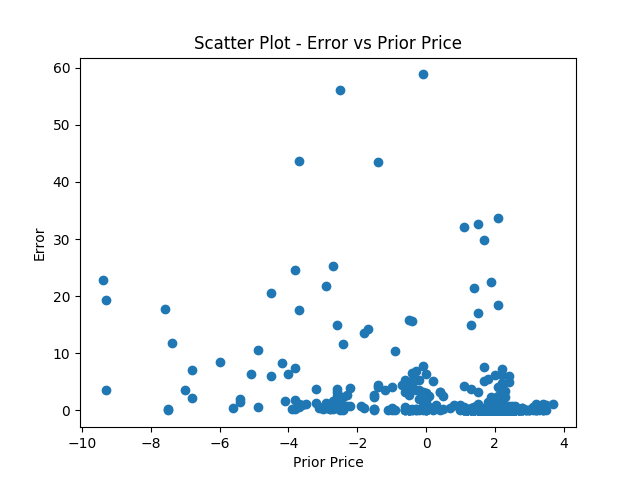

In [9]:
histavg = numpy.array(A[:,1])
pprice = numpy.array(A[:,0])
errnew = numpy.array(err)

matplotlib.pyplot.scatter(pprice,numpy.square(errnew))
matplotlib.pyplot.show()
maxval = max(pprice)
scipy.io.savemat('test.mat', dict(histavg=histavg, pprice=pprice, errnew= errnew,y=y,A=A,Ax=Ax,coeff = x))
minval = min(pprice)
matplotlib.pyplot.xlabel('Prior Price')
matplotlib.pyplot.ylabel('Error')
matplotlib.pyplot.title('Scatter Plot - Error vs Prior Price')
matplotlib.pyplot.savefig('Scatter_Prior')

## Getting Gaussians at some xaxis range


/home/vegnesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/vegnesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


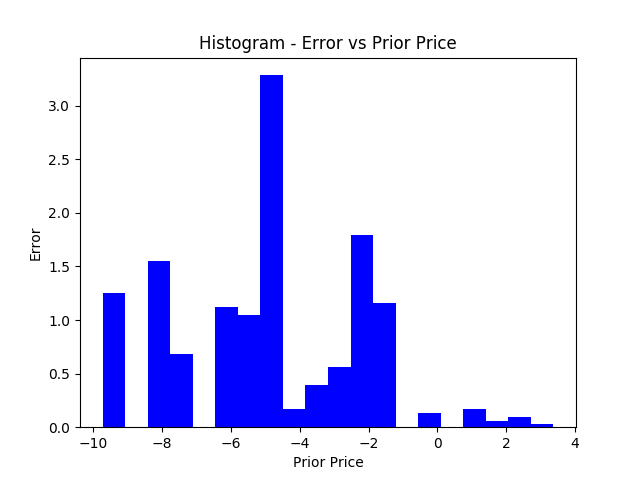

In [10]:
nbins = 20
ppvec = numpy.linspace(minval,maxval,nbins+1)
width = ppvec[1] - ppvec[0]
binindexvec = []
totvec = numpy.zeros([nbins,1])
sumvec = numpy.zeros([nbins,1])
sumsqrvec = numpy.zeros([nbins,1])
for ival  in range(len(pprice)):
    temp = ppvec[ppvec<pprice[ival]]
    binindexvec.append(len(temp))
    totvec[numpy.int(binindexvec[ival]-1)]    = totvec[numpy.int(binindexvec[ival]-1)]    + numpy.double(1)
    sumvec[binindexvec[ival]-1]    = sumvec[binindexvec[ival]-1]    + numpy.double(errnew[ival])
    sumsqrvec[binindexvec[ival]-1] = sumsqrvec[binindexvec[ival]-1] + numpy.double(errnew[ival]**2)
meanvec   = numpy.divide(sumvec,totvec)
meanvec   = meanvec.flatten()
sumsqrvec = numpy.divide(sumsqrvec,totvec)
sumsqrvec = sumsqrvec.flatten()
stdvevvec = sumsqrvec - meanvec**2
matplotlib.pyplot.bar(ppvec[0:nbins],abs(meanvec), width, color="blue")
#matplotlib.pyplot.bar(ppvec[0:nbins],stdvevvec, width, color="red")

matplotlib.pyplot.xlabel('Prior Price')
matplotlib.pyplot.ylabel('Error')
matplotlib.pyplot.title('Histogram - Error vs Prior Price')
matplotlib.pyplot.savefig('Histogram_Prior')

/home/vegnesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/vegnesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


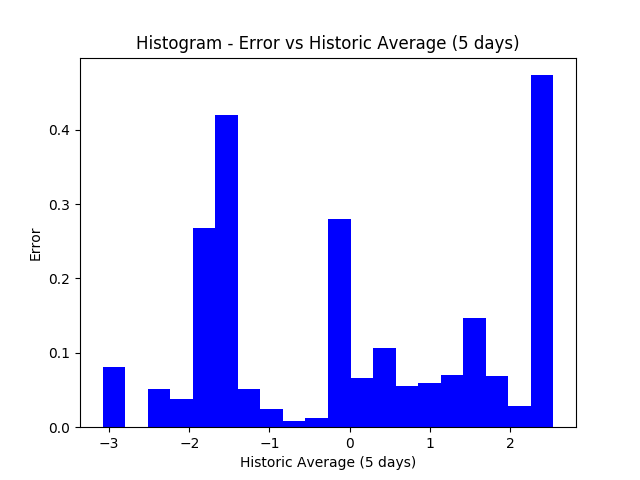

In [11]:
nbins = 20
minvalh = min(histavg )
maxvalh = max(histavg)
histvec = numpy.linspace(minvalh,maxvalh,nbins+1)
width = histvec[1] - histvec[0]
binindexvec = []
totvec = numpy.zeros([nbins,1])
sumvec = numpy.zeros([nbins,1])
sumsqrvec = numpy.zeros([nbins,1])
for ival  in range(len(histavg )):
    temp = histvec[histvec<histavg [ival]]
    binindexvec.append(len(temp))
    totvec[numpy.int(binindexvec[ival]-1)]    = totvec[numpy.int(binindexvec[ival]-1)]    + numpy.double(1)
    sumvec[binindexvec[ival]-1]    = sumvec[binindexvec[ival]-1]    + numpy.double(errnew[ival])
    sumsqrvec[binindexvec[ival]-1] = sumsqrvec[binindexvec[ival]-1] + numpy.double(errnew[ival]**2)
meanvec   = numpy.divide(sumvec,totvec)
meanvec   = meanvec.flatten()
sumsqrvec = numpy.divide(sumsqrvec,totvec)
sumsqrvec = sumsqrvec.flatten()
stdvevvec = sumsqrvec - meanvec**2
matplotlib.pyplot.bar(histvec[0:nbins],abs(meanvec), width, color="blue")
#matplotlib.pyplot.bar(histvec[0:nbins],stdvevvec, width, color="red")

matplotlib.pyplot.xlabel('Historic Average (5 days)')
matplotlib.pyplot.ylabel('Error')
matplotlib.pyplot.title('Histogram - Error vs Historic Average (5 days)')
matplotlib.pyplot.savefig('Histogram_HA')

<IPython.core.display.Javascript object>


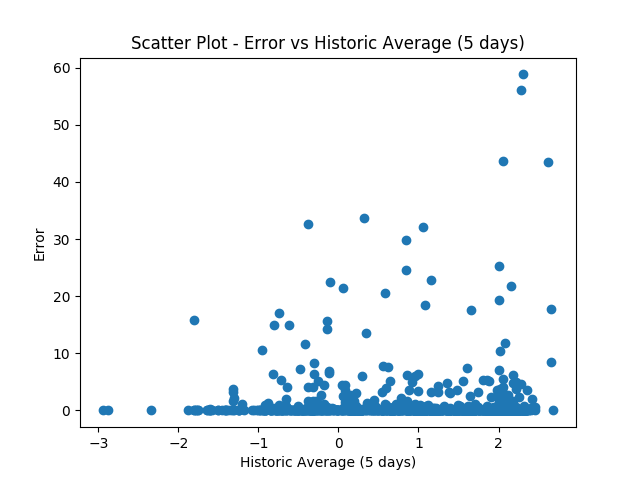

In [12]:
matplotlib.pyplot.scatter(histavg,numpy.square(errnew))
matplotlib.pyplot.show()

matplotlib.pyplot.xlabel('Historic Average (5 days)')
matplotlib.pyplot.ylabel('Error')
matplotlib.pyplot.title('Scatter Plot - Error vs Historic Average (5 days)')
matplotlib.pyplot.savefig('Scatter_HA')

In [11]:
matplotlib.pyplot.hist(err, 100, normed=1, facecolor='green', alpha=0.75)
matplotlib.pyplot.show()


In [12]:
scipy.stats.probplot(numpy.array(err).flatten(), dist="norm", plot=matplotlib.pyplot)
matplotlib.pyplot.show()

In [13]:
dateDict={}
timeDict={}
for dt in dates:
    dt_date=dt.date()
    dt_time=dt.time()
    dateDict[dt_date]=True
    timeDict[dt_time]=True
    
for n,t in enumerate(sorted(dateDict.keys())):
    dateDict[t]=n
    
for n,d in enumerate(sorted(timeDict.keys())):
    timeDict[d]=n
    
    
N_times=len(timeDict.keys())
N_days=len(dateDict.keys())
err_matrix=numpy.full([N_days,N_times], numpy.nan)

In [14]:
for n,dt in enumerate(indices):
    row=dateDict[dt.date()]
    col=timeDict[dt.time()]
    err_matrix[row,col]=err[n]

In [15]:
acf=numpy.empty(N_times)*numpy.nan
for n in range(N_times):
    M_1=err_matrix[:,:(N_times-n)]
    M_2=err_matrix[:,n:]
    prod=numpy.multiply(M_1,M_2)
    corr=numpy.nanmean(prod)
    acf[n]=corr   

In [16]:
matplotlib.pyplot.bar(range(N_times),acf,align='center', alpha=0.5)
matplotlib.pyplot.show()

In [17]:
ERR=numpy.ravel(err)
def loglikelihood(x,y=None):
    if y is None: #one argument; x=(df,scale)
        (df,scale)=x
    else:
        df=x
        scale=y
    temp=scipy.stats.t.pdf(err,df=df,scale=scale)
    return -numpy.average(numpy.log(temp))

loglikelihood_v=numpy.vectorize(loglikelihood)

In [18]:
N=1

def callback(x):
    global N
    print("N="+str(N)+"; x="+str(x))
    N+=1
    
res=scipy.optimize.minimize(loglikelihood,[3,.001],bounds=[(0,None),(0,None)],callback=callback)
print(res)
(df_est,scale_est)=res.x
print("estimated df="+str(df_est))
print("estimated scale="+str(scale_est))

N=1; x=[ 2.99898794  1.00099949]
N=2; x=[ 3.01459548  0.3059123 ]
      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.05518622,  0.57377798])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 189
      nit: 2
   status: 2
  success: False
        x: array([ 3.01459548,  0.3059123 ])
estimated df=3.0145954823
estimated scale=0.305912300064


/home/vegnesh/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1649: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [19]:
df_mesh = numpy.arange(.1,1, 0.005)
scale_mesh = numpy.arange(0.01,.6, 0.01)
df_mesh, scale_mesh = numpy.meshgrid(df_mesh,scale_mesh)
Z = -loglikelihood_v(df_mesh,scale_mesh)

<IPython.core.display.Javascript object>


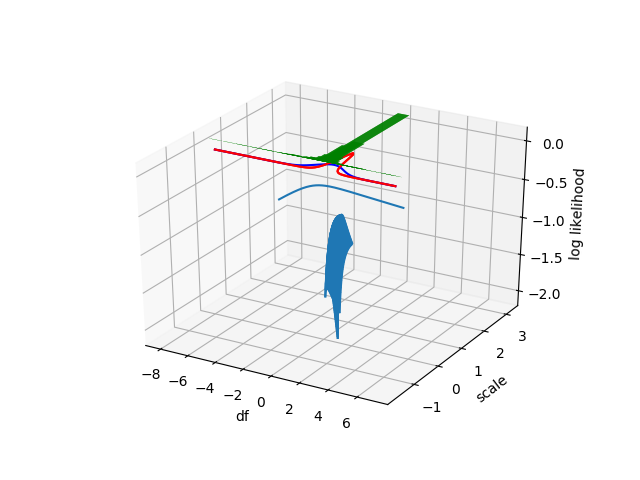

In [20]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
ax.plot_wireframe(df_mesh,scale_mesh,Z)
ax.set_xlabel('df')
ax.set_ylabel('scale')
ax.set_zlabel('log likelihood')
matplotlib.pyplot.show()

In [21]:
df_range = numpy.arange(.1,7,.005)
Z_temp=-loglikelihood_v(df_range,scale_est)
matplotlib.pyplot.plot(df_range,Z_temp)
matplotlib.pyplot.show()

There definitely is a maximum at about 1.5

In [22]:
n, bins, patches=matplotlib.pyplot.hist(err, 100, normed=True, facecolor='green', alpha=0.75)

mids=(bins[1:]+bins[:-1])/2
widths=bins[1:]-bins[:-1]
t_heights=(scipy.stats.t.cdf(bins[1:],df=df_est,scale=scale_est)-scipy.stats.t.cdf(bins[:-1],df=df_est,scale=scale_est))/widths
matplotlib.pyplot.plot(mids,t_heights,color='red')

std=numpy.std(ERR)
n_heights=(scipy.stats.norm.cdf(bins[1:],scale=std)-scipy.stats.norm.cdf(bins[:-1],scale=std))/widths
matplotlib.pyplot.plot(mids,n_heights,color='blue')

matplotlib.pyplot.show()


It seems that the fat tails make the Gaussian density (blue) wider than it should be.  The t distribution (red) seems much better.

In [23]:
n, bins, patches=matplotlib.pyplot.hist(err, 100, normed=True, facecolor='green', alpha=0.75)

mids=(bins[1:]+bins[:-1])/2
widths=bins[1:]-bins[:-1]
t_heights=(scipy.stats.t.cdf(bins[1:],df=df_est,scale=scale_est)-scipy.stats.t.cdf(bins[:-1],df=df_est,scale=scale_est))/widths
matplotlib.pyplot.plot(mids,t_heights,color='red')
matplotlib.pyplot.show()

In [24]:
numpy.savetxt("err.csv", ERR, delimiter=",")